In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

# Load data

In [2]:
week1_anoms = xr.open_dataset('/glade/work/jhayron/Weather_Regimes/weekly_anomalies/week1_z500_anoms_v2.nc')

week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v2.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v2.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

# week1_anoms = week1_anoms.sel(time=df_wr_2.index)
week1_anoms = week1_anoms.sel(time=df_wr.index)
week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)

In [3]:
# region for clustering
lat0=10; lat1=70; lon0=210; lon1=320

In [4]:
week1_anoms = week1_anoms.where((week1_anoms.lon<=lon0)|(week1_anoms.lon>=lon1),drop=True)

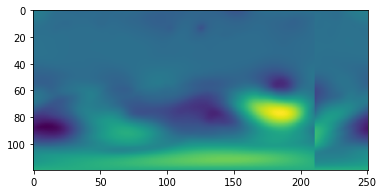

In [5]:
plt.imshow(week1_anoms.z500_anomalies.values[0])

In [6]:
week1_anoms = week1_anoms.roll(lon=40,roll_coords=True)

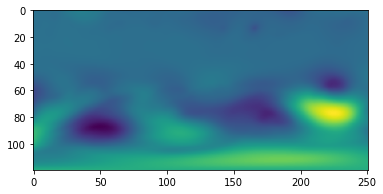

In [7]:
plt.imshow(week1_anoms.z500_anomalies.values[0])

## Quick check anomalies

In [3]:
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1_v2  = xr.open_dataset(f'{path_files}era5_z500_anoms_mean_week1.nc')

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


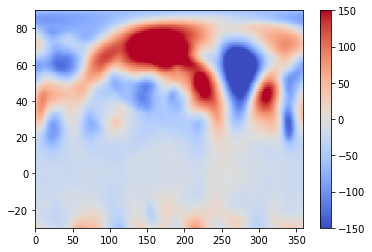

In [4]:
plt.pcolormesh(anoms_week_1_v2.lon,anoms_week_1_v2.lat,
               anoms_week_1_v2.isel(time= 0).anom,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


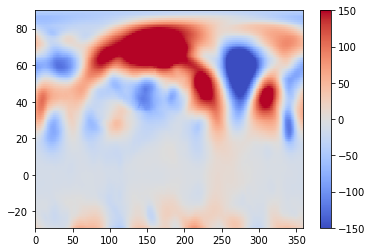

In [5]:
plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,
               week1_anoms.sel(time = datetime(1999,1,4)).z500_anomalies/9.82,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

## Quick check WR

In [12]:
serie_wr_week = np.load(f'{path_files}Serie_WR_Week{1}.npy')

In [13]:
df_old = pd.DataFrame(serie_wr_week,index = pd.to_datetime(anoms_week_1_v2.date_range.values))

In [14]:
df_old2 = copy.deepcopy(df_old)

In [15]:
df_old2[df_old==0] = 1
df_old2[df_old==1] = 0
df_old2[df_old==2] = 3
df_old2[df_old==3] = 2


In [16]:
df_comparison = pd.concat([df_old2,df_wr.week1],axis=1).dropna()

# Build model

In [8]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

## Tests

In [35]:
week_output_wr = df_wr.week2.values.astype(int)
# week_output_wr = df_wr_2.week2.values.astype(int)

# Make Y categorical
serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

# # Scale by standard deviation
# standard_deviation = week1_anoms.z500_anomalies.std(dim='time')
# scaled_x = week1_anoms.z500_anomalies / standard_deviation

Min = week1_anoms.z500_anomalies.min(dim='time')
Max = week1_anoms.z500_anomalies.max(dim='time')

scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

indices = np.arange(len(serie_wr_categorical))
#Reshape X
scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

indices_test = np.where(df_wr.week2.index.year>2010)[0]
indices_train_val = np.where(df_wr.week2.index.year<=2010)[0]

X_train, X_val, y_train, y_val, indices_train, indices_val \
    = train_test_split(scaled_x[indices_train_val], serie_wr_categorical[indices_train_val], indices_train_val, test_size=0.15, random_state=42)

X_test = scaled_x[indices_test]
y_test = serie_wr_categorical[indices_test]

In [36]:
wr_persistence = df_wr.week1.values.astype(int)[indices_test]
serie_wr_persistence_categorical = to_categorical(wr_persistence)

In [37]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model

keras.backend.clear_session()

# from tensorflow import set_random_seed
# set_random_seed(2)
model = create_model()

# visualkeras.layered_view(model).show() # display using your system viewer
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
# visualkeras.layered_view(model, scale_xy=1, legend=True,to_file=f'{path_figures}CNN_v1.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

batch_size = 128
epochs = 200
earlystop = EarlyStopping(monitor='val_loss', patience=5)
filepath = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights/checkpoint_w2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                             mode='auto',save_weights_only=False)
model.fit(X_train, y_train, batch_size=batch_size,\
    epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])


Epoch 1/200
15/15 [==============================] - 4s 292ms/step - loss: 1.3781 - accuracy: 0.3128 - val_loss: 1.3692 - val_accuracy: 0.3178
Epoch 2/200
15/15 [==============================] - 3s 212ms/step - loss: 1.3606 - accuracy: 0.3249 - val_loss: 1.3571 - val_accuracy: 0.3271
Epoch 3/200
15/15 [==============================] - 3s 214ms/step - loss: 1.3489 - accuracy: 0.3474 - val_loss: 1.3448 - val_accuracy: 0.3738
Epoch 4/200
15/15 [==============================] - 3s 215ms/step - loss: 1.3376 - accuracy: 0.3502 - val_loss: 1.3314 - val_accuracy: 0.3769
Epoch 5/200
15/15 [==============================] - 3s 225ms/step - loss: 1.3225 - accuracy: 0.3672 - val_loss: 1.3186 - val_accuracy: 0.3894
Epoch 6/200
15/15 [==============================] - 3s 211ms/step - loss: 1.3072 - accuracy: 0.3777 - val_loss: 1.3046 - val_accuracy: 0.3956
Epoch 7/200
15/15 [==============================] - 3s 215ms/step - loss: 1.2905 - accuracy: 0.4123 - val_loss: 1.2910 - val_accuracy: 0.4143

In [38]:
model.load_weights(filepath)

In [39]:
model.evaluate(x=X_test,y=y_test)

14/14 [==============================] - 0s 27ms/step - loss: 1.2058 - accuracy: 0.4467


[1.205755352973938, 0.44671201705932617]

In [40]:
log_loss(y_test,serie_wr_persistence_categorical)

19.188209109836155

In [41]:
log_loss(y_test,model.predict(X_test))

1.2057553203670888

In [42]:
accuracy_score(y_test,serie_wr_persistence_categorical)

0.4444444444444444

In [43]:
y_predicted_test = model.predict(X_test)

In [44]:
y_predicted_test_discrete = np.zeros_like(y_predicted_test)
for i in range(len(y_predicted_test_discrete)):
    y_predicted_test_discrete[i,np.argmax(y_predicted_test,axis=1)[i]] = 1

In [45]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 14ms/step - loss: 1.2058 - accuracy: 0.4467


[1.205755352973938, 0.44671201705932617]

In [46]:
accuracy_score(y_test,y_predicted_test_discrete)

0.4467120181405896

# Train definitive

In [47]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model


In [48]:
loss_weeks_model = []
loss_weeks_persistence = []
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week2','week3','week4','week5','week6']:
    print(week)
    #### ORGANIZE DATA ####
    
    week_output_wr = df_wr[week].values.astype(int)
    # Make Y categorical
    serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

    # # Scale by min-max
    Min = week1_anoms.z500_anomalies.min(dim='time')
    Max = week1_anoms.z500_anomalies.max(dim='time')
    scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

    indices = np.arange(len(serie_wr_categorical))
    
    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)
    
    # Split train, test, and validation
    X_train, X_test, y_train, y_test, indices_train, indices_test \
        = train_test_split(scaled_x, serie_wr_categorical, indices, test_size=0.15, random_state=42)

    X_train, X_val, y_train, y_val, indices_train, indices_val \
        = train_test_split(X_train, y_train, indices_train, test_size=0.15/0.85, random_state=42) 

    wr_persistence = df_wr.week1.values.astype(int)[indices_test]
    serie_wr_persistence_categorical = to_categorical(wr_persistence)
    
    #### TRAIN ####
    
    keras.backend.clear_session()
    model = create_model()
    batch_size = 128
    epochs = 200
    
    earlystop = EarlyStopping(monitor='val_loss', patience=5)
    filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_{week}_v2.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                 mode='auto',save_weights_only=False)
    model.fit(X_train, y_train, batch_size=batch_size,\
        epochs=epochs,verbose=0,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])
    
    #### EVAL ####
    
    model.load_weights(filepath)
    model.save(filepath)
    metrics_model = model.evaluate(x=X_test,y=y_test)
    acc_temp = metrics_model[1]
    loss_temp = metrics_model[0]
    acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
    loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
    print('loss/acc model')
    print(metrics_model)
    print('loss/acc persistence')
    print([loss_persistence,acc_persistence])
    
    loss_weeks_model.append(loss_temp)
    loss_weeks_persistence.append(loss_persistence)
    acc_weeks_model.append(acc_temp)
    acc_weeks_persistence.append(acc_persistence)


week2
13/13 [==============================] - 0s 17ms/step - loss: 1.2276 - accuracy: 0.4536
loss/acc model
[1.2276270389556885, 0.4536082446575165]
loss/acc persistence
[18.69366763793316, 0.4587628865979381]
week3
13/13 [==============================] - 0s 14ms/step - loss: 1.3266 - accuracy: 0.3660
loss/acc model
[1.3266243934631348, 0.3659793734550476]
loss/acc persistence
[23.856680604600413, 0.30927835051546393]
week4
13/13 [==============================] - 0s 15ms/step - loss: 1.3078 - accuracy: 0.4046
loss/acc model
[1.3077664375305176, 0.40463918447494507]
loss/acc persistence
[26.349169622991504, 0.23711340206185566]
week5
13/13 [==============================] - 0s 14ms/step - loss: 1.3440 - accuracy: 0.3325
loss/acc model
[1.3440220355987549, 0.3324742317199707]
loss/acc persistence
[26.171134693106424, 0.2422680412371134]
week6
13/13 [==============================] - 0s 13ms/step - loss: 1.3645 - accuracy: 0.3067
loss/acc model
[1.3644880056381226, 0.30670103430747986]

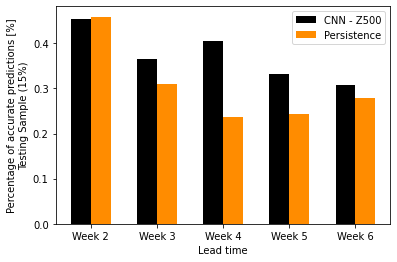

In [49]:
plt.bar(np.arange(5),acc_weeks_model,width=-0.3,align='edge',label='CNN - Z500',color='k')
plt.bar(np.arange(5),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (15%)')
plt.xticks(np.arange(5),['Week 2','Week 3','Week 4','Week 5','Week 6'])
plt.xlabel('Lead time')
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Skill_CNNv2vsPersistence.png',bbox_inches='tight')


In [71]:
keras.models.load_model(f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_week2.h5',
                       custom_objects={'ReLU': ReLU})